Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Всего датасет содержит 159 записей. Мы предварительно зарезервировали часть датасета для задания по преодолению бейслайна (baseline). В настоящем задании подразумевается работа с датасетом, содержащим 119 записей.

# 0. Применение полиномиальной регрессии для предсказания непрерывного параметра

Представленный набор данных — это набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Наша цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе. Сами признаки, быть может, нужно синтезировать из тех, что известны.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки с параметрами, указанными в вашем задании. Используйте стратификацию по колонке <code>Species</code>. Стратификация позволит сохранить доли представленных объектов (по представителям типов рыб) в тренировочной и тестовой выборках.

In [2]:
# < ENTER YOUR CODE HERE > 
data = pd.read_csv('fish_train.csv', na_values='?')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  119 non-null    object 
 1   Weight   119 non-null    float64
 2   Length1  119 non-null    float64
 3   Length2  119 non-null    float64
 4   Length3  119 non-null    float64
 5   Height   119 non-null    float64
 6   Width    119 non-null    float64
dtypes: float64(6), object(1)
memory usage: 6.6+ KB


Вычислите выборочное среднее колонки <code>Width</code> полученной тренировочной выборки.

In [3]:
# < ENTER YOUR CODE HERE > 
X = data.iloc[:, data.columns != "Weight"]
y = data.iloc[:, data.columns == "Weight"]
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=29,
                                                    stratify=X.Species)
X_train.Width.mean()

4.5745031578947355

# 1. Построение базовой модели

Избавьтесь от категориальных признаков и обучите модель линейной регрессии (<code>LinearRegression()</code>) на тренировочном наборе данных. Выполните предсказания для тестового набора данных. Оцените модель при помощи метрики <code>r2_score()</code>.

In [4]:
# < ENTER YOUR CODE HERE > 
X_train = X_train.iloc[:, X_train.columns != "Species"]
X_test = X_test.iloc[:, X_test.columns != "Species"]
model = LinearRegression()
model.fit(X_train, y_train)

r2_score(y_test, model.predict(X_test))

0.7968529639774724

# 2. Добавление предварительной обработки признаков.

## Использование PCA

При помощи, например, <code>sns.heatmap()</code>, постройте матрицу корреляций признаков тренировочного набора данных и определите тройку наиболее коррелированных между собой признаков.

<Axes: >

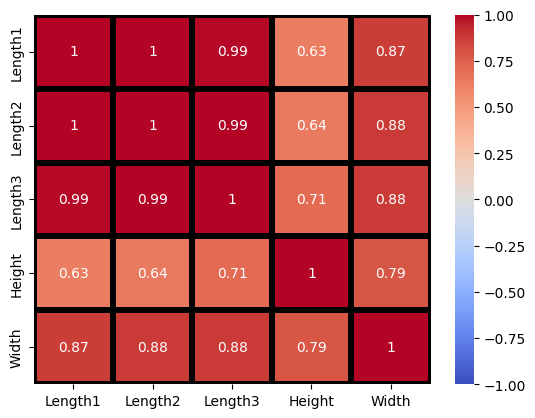

In [5]:
# < ENTER YOUR CODE HERE > 
sns.heatmap(X_train.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

Линейные модели достаточно плохо реагируют на коррелированные признаки, поэтому от таких признаков имеет смысл избавиться еще до начала обучения.

Для уменьшения количества неинформативных измерений используйте метод главных компонент. 

1) Примените метод главных компонент (<code>PCA(n_components=3, svd_solver='full')</code>) для трех найденных наиболее коррелированных признаков. 

2) Вычислите долю объясненной дисперсии при использовании только первой главной компоненты. 

3) Замените три наиболее коррелированных признака на новый признак <code>Lengths</code>, значения которого совпадают со значениями счетов первой главной компоненты.

In [6]:
# < ENTER YOUR CODE HERE > 
def pca_fit(n_components, data):
    #features_components = [ 'principal component ' + str(x) for x in range(1, n_components+1) ]

    pca = PCA(n_components=n_components, svd_solver = "full")
    principal_components = pca.fit_transform(data)
    
    return pca, principal_components

In [7]:
X_train_max_corr = X_train.loc[:,['Length1', 'Length2', 'Length3']]
pca, res = pca_fit(1, X_train_max_corr)
pca.explained_variance_ratio_[0]

0.9963136613344492

In [8]:
X_train = X_train.iloc[:, ~X_train.columns.isin(["Length1","Length2","Length3"])]
X_train['Lengths'] = res[:,0]
X_train.head()

,Height,Width,Lengths
117,6.1100,3.4075,-12.801244
2,12.4440,5.1340,1.201229
54,14.2266,4.9594,4.610673
10,5.9175,3.3075,-14.530236
63,5.6925,3.6675,-14.530236


Примените полученное преобразование для тех же признаков в тестовом наборе данных. Обратите внимание, что заново обучать преобразование `PCA` не нужно. Аналогично предыдущему этапу замените три рассмотренных признака на один.

In [9]:
# < ENTER YOUR CODE HERE > 
X_test_max_corr = X_test.loc[:,['Length1', 'Length2', 'Length3']] 
res_test = pca.transform(X_test_max_corr)
X_test = X_test.iloc[:, ~X_test.columns.isin(['Length1','Length2','Length3'])]
X_test['Lengths'] = res_test[:,0]


In [10]:
X_test.head()

,Height,Width,Lengths
103,8.5376,3.2944,-14.269183
67,7.1672,4.3350,-3.407231
102,2.0832,1.2772,-30.857276
7,14.9380,5.1975,8.373265
4,5.6925,3.5550,-14.530236


Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи <code>r2_score()</code>.

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.794350983999933

Видно, что точность значительно не изменилась.

## Модификация признаков

Постройте графики зависимостей признаков от целевой переменной, например, при помощи <code>sns.pairplot()</code>.

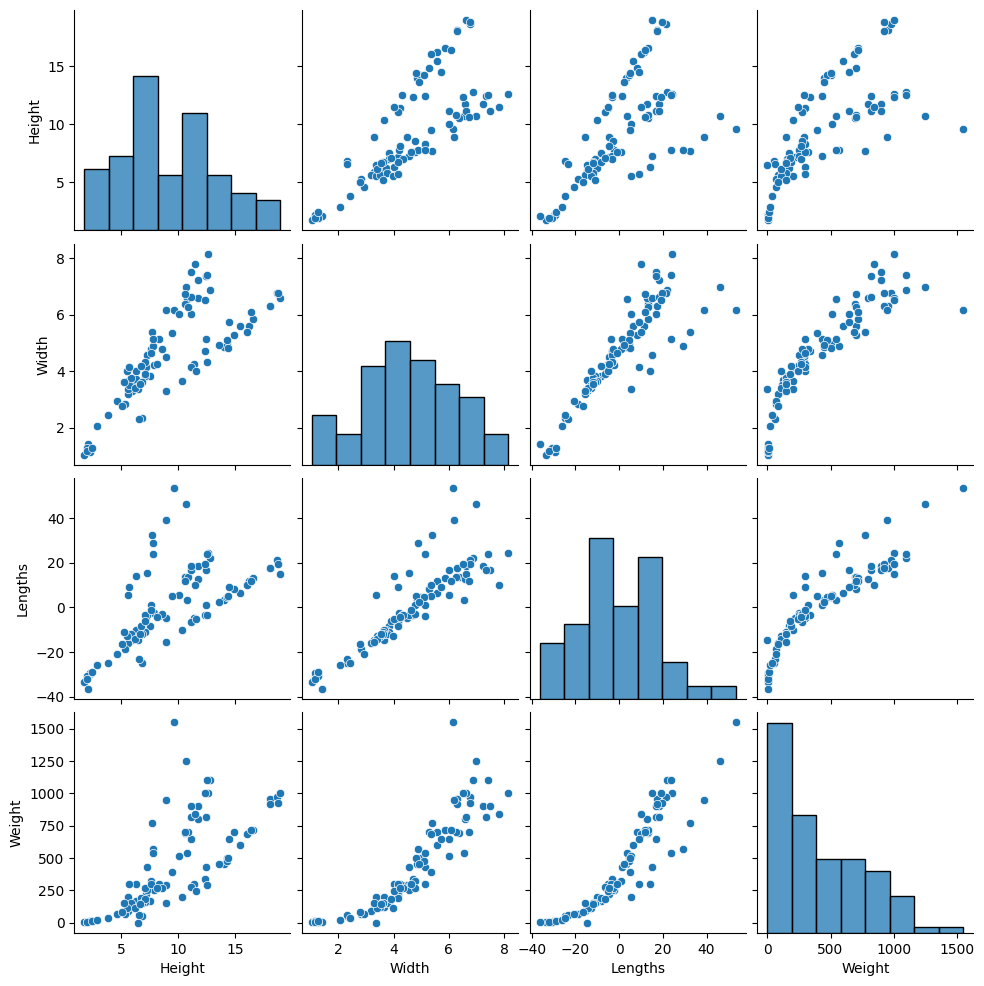

In [12]:
# < ENTER YOUR CODE HERE > 
df = pd.concat([X_train, y_train],axis = 1)
sns.pairplot(df)

Видно, что масса, вообще говоря, нелинейно зависит от остальных параметров. Значит, чтобы линейная модель хорошо справлялась с предсказанием, признаки имеет смысл преобразовать так, чтобы зависимость стала более похожей на линейную. Но как придумать такую зависимость?

Логично предположить, что масса рыбы должна каким-то гладким образом зависеть от остальных параметров, отвечающих так или иначе за размеры. Если впомнить, что масса — это произведение плотности на объем, то

$$
m = \rho \cdot V.
$$

Допустим, что средняя плотность у всех рыб одинаковая, и вспомним, что при гомотетии объем объекта зависит от линейных размеров как куб, тогда получим

$$
m\sim V\sim d^3
$$

Все признаки тренировочного и тестового наборов данных, отвечающие так или иначе за размеры (<code>Height, Width, Lengths</code>), возведите в третью степень, и проверьте, стала ли зависимость массы от этих признаков похожа на линейную.

In [13]:
# < ENTER YOUR CODE HERE > 
def multiply3(n):
    return n ** 3
df.head()

,Height,Width,Lengths,Weight
117,6.1100,3.4075,-12.801244,120.0
2,12.4440,5.1340,1.201229,430.0
54,14.2266,4.9594,4.610673,500.0
10,5.9175,3.3075,-14.530236,115.0
63,5.6925,3.6675,-14.530236,125.0


In [14]:
X_train['Height'] = X_train['Height'].apply(multiply3)
X_train['Width'] = X_train['Width'].apply(multiply3)
X_train['Lengths'] = X_train['Lengths'].apply(multiply3)

In [15]:
X_train.head()

,Height,Width,Lengths
117,228.099131,39.564674,-2097.763645
2,1926.992424,135.321746,1.733314
54,2879.409033,121.979658,98.015085
10,207.211951,36.182582,-3067.736068
63,184.462936,49.329915,-3067.736068


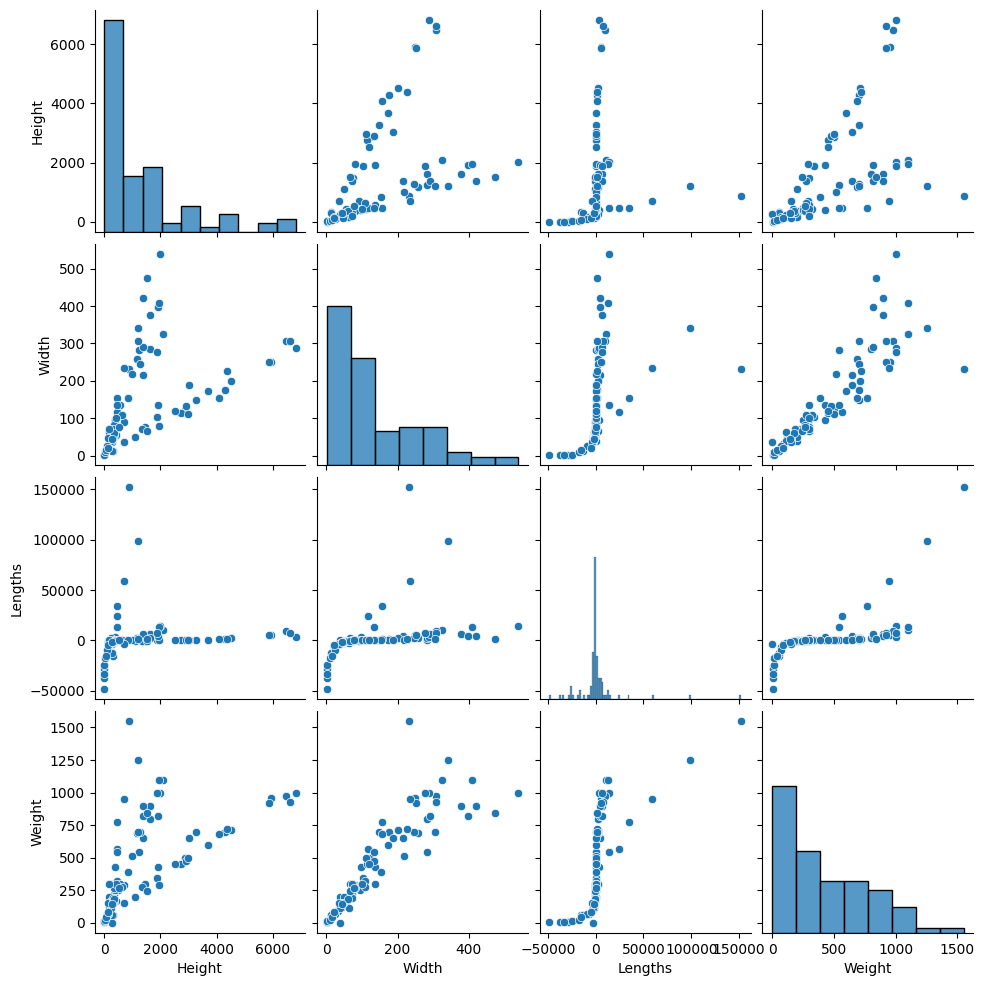

In [16]:
X_test["Height"] = X_test["Height"].apply(multiply3)
X_test["Width"] = X_test["Width"].apply(multiply3)
X_test["Lengths"] = X_test["Lengths"].apply(multiply3)
df = pd.concat([X_train, y_train], axis = 1)
sns.pairplot(df)

Введите выборочное среднее колонки <code>Width</code> тренировочного набора данных после возведения в куб.

In [17]:
# < ENTER YOUR CODE HERE > 
X_train.Width.mean()

134.6390734707923

Выберите изображения, соответствующие зависимости <code>Weight</code> от <code>Width</code> до преобразования и после.

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи `r2_score()`.

In [18]:
# < ENTER YOUR CODE HERE > 
model = LinearRegression()
model.fit(X_train, y_train)
r2_score(model.predict(X_test), y_test)

0.9240150754705586

In [19]:
r2_score(y_test,model.predict(X_test))

0.9306454466604968

Обратите внимание на то, как такая нехитрая работа с признаками помогла разительно улучшить точность модели!

## Добавление категориальных признаков

Произведите <code>one-hot</code> кодировние категориального признака `Species`, например, с помощью <code>pd.get_dummies()</code>.

Обучите модель линейной регресси на полученных тренировочных данных. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

<b>Примечание</b>: Мы специально использовали стратифицированное разделение, чтобы все значения категориального признака <code>Species</code> присутствовали во всех наборах данных. Но такое возможно не всегда. Про то, как с этим бороться можно почитать, [например, здесь](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

In [20]:
# < ENTER YOUR CODE HERE > 
X_train = pd.merge(X_train, X.Species, left_index=True, right_index=True, how="left")
X_test = pd.merge(X_test, X.Species,left_index=True, right_index=True, how="left")
X_train.head()

,Height,Width,Lengths,Species
117,228.099131,39.564674,-2097.763645,Perch
2,1926.992424,135.321746,1.733314,Bream
54,2879.409033,121.979658,98.015085,Bream
10,207.211951,36.182582,-3067.736068,Perch
63,184.462936,49.329915,-3067.736068,Perch


In [21]:
X_train = pd.get_dummies(X_train,columns=['Species'])
X_test = pd.get_dummies(X_test,columns=['Species'])
X_train.head()

,Height,Width,Lengths,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
117,228.099131,39.564674,-2097.763645,False,False,True,False,False,False,False
2,1926.992424,135.321746,1.733314,True,False,False,False,False,False,False
54,2879.409033,121.979658,98.015085,True,False,False,False,False,False,False
10,207.211951,36.182582,-3067.736068,False,False,True,False,False,False,False
63,184.462936,49.329915,-3067.736068,False,False,True,False,False,False,False


In [22]:
model = LinearRegression()
model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.950512335530221

И снова точность возрасла.

Как можно увидеть, после `one-hot` кодирования признаки стали коррелированы. От этого можно избавиться, например, при помощи параметра `drop_first=True`. Заново обучите модель после исправления этого недочета. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

In [23]:
# < ENTER YOUR CODE HERE > 
X_train = X_train.iloc[:, X_train.columns != 'Species_Bream']

In [24]:
X_test = X_test.iloc[:, X_test.columns != 'Species_Bream']

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.9505123355302213

На таком сравнительно небольшом наборе данных, впрочем, разницы мы не видим.